# Diffusion maps with single sigma

* Modified from [Diffusion-Maps-in-Julia](https://github.com/chingruchung/Diffusion-Maps-in-Julia) by Ching-Ru Chung.
* Change package `PyPlot` to `Plots`
* Choose sigma as 25% in total distance

#### Author: Te-Sheng Lin, 2020

In [175]:
using LinearAlgebra
using MAT
using Plots
using Statistics
using Clustering
#using BenchmarkTools
#using Distances

## 1. Read Data

Given a data set $X=\{x_1,...,x_n\} \in \mathbb{R}^d, \, d\ge 2$. 

Data stored in "Data.mat" with variable named "data".

#### Data2.mat
In this example the data are randomly sampled from three circles with the same center. 

The $1\sim 61$ points corresponds to the inner circle, $62\sim 200$ corresponds to the second circle while $201\sim 299$ is the outer circle.

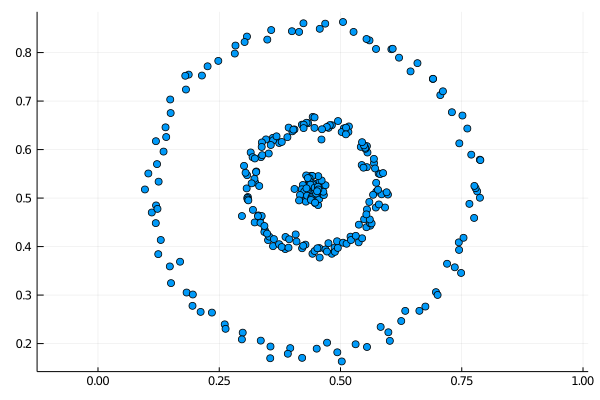

In [24]:
file = matread("Data2.mat");
X = file["data"];

# Visualize the first two dimension of the data
scatter(X[:,1], X[:,2], aspect_ratio=:equal, leg=false)

## 2. Define a distance matrix $E$

Let $E$ be the square root of the Euclidean distance matrix ([EDM](https://en.wikipedia.org/wiki/Euclidean_distance_matrix)) with entries 

$$ E_{ij}=\| x_{i}-x_{j}\|_2 $$

#### Alternatively we can simply use 'pairwise' in Distances package, the performance is the following:

@btime get_E(X);
> 4.315 ms (133655 allocations: 12.92 MiB)

@btime pairwise(Euclidean(), X, dims=1);
> 152.584 μs (5 allocations: 701.11 KiB)


In [143]:
# input: X - data points
# output: E - distance matrix
#
function get_E(X)
    n = size(X,1); # number of points
    E = zeros(n,n); # the diagonal entries are 0
    
    for ii=1:n
        for jj=ii+1:n
            E[ii,jj] = norm(X[ii,:] - X[jj,:]);
            E[jj,ii] = E[ii,jj];
        end
    end
    
    return E;
end

get_E (generic function with 1 method)

In [144]:
# get the distance matrix D
E = get_E(X);

# One can also use the following:
#E = pairwise(Euclidean(), X, dims=1);

## 3. Define a kernel matrix $K$

Let $K$ be a kernel matrix with entries $ K_{ij}=k(x_{i},x_{j}) $, where $k$ is the Guassian kernel
$$ k(x,y) = e^{-\frac{\lVert x-y \rVert^2}{\sigma^2}}, $$
and $\sigma$ is a constant chosen roughly as the $25\%$th smallest value of the distance matrix.

In [160]:
# evaluate sigma
E_sort = sort(E, dims=2);

n = size(X,1);
k = round(Int64, n/4);
sigma_loc = E_sort[:, k+1];
sigma = median(sigma_loc)

0.13538798665176516

In [161]:
# input 1: E - distance matrix
# input 2: sigma - constant
#
# output: K - kernal matrix
#
function get_K(E, sigma)
    K = exp.(-(E.^2) ./ (sigma^2));
    
    return K;
end

get_K (generic function with 1 method)

In [162]:
# get the kernal matrix K
K = get_K(E, sigma);

## 4. Construct a matrix $Q$ that related to diffusion matrix

Diffusion matrix, 
$$P=D^{-1}K,$$
where $D_{ii} = \sum^n_{j=1} K_{ij}$, is a matrix that describe the connectivity between two data points, which can be consider as the probability of jumping from one point to another in one step of random walk. 
Consider a matrix $Q$, 
$$ Q=D^{-\frac{1}{2}}KD^{-\frac{1}{2}},$$
it can be shown that the eigenvalues of $P$ and $Q$ are exactly the same, while the eigenvectors of $P$ are 
$$ v = D^{-1/2}v_Q,$$
where $v_Q$'s are the eigenvectors of $Q$.

In [163]:
# input: K - kernal matrix
#
# output 1: Q
# output 2: d_sq - sqrt{D}
#
function get_Q(K)
    n = size(K,1);
    Q = zeros(n,n);
    d_sq = zeros(n);
    
    # d_sq = sqrt{D}
    for ii = 1:n
        d_sq[ii] = sqrt(sum(K[ii,:]));
    end
    
    # get components of Q
    for ii = 1:n
        for jj = 1:n
            Q[ii,jj] = K[ii,jj]/(d_sq[ii]*d_sq[jj]);
        end
    end
    
    return Q, d_sq;
end

get_Q (generic function with 1 method)

In [164]:
# get Q and d_sq
Q, d_sq = get_Q(K);

## 5. Find eigenvectors and eigenvalues of the diffusion matrix

As we mention earlier,
>the eigenvalues of $P$ and $Q$ are exactly the same, while the eigenvectors of $P$ are 
$$ v = D^{-1/2}v_Q,$$ where $v_Q$'s are the eigenvectors of $Q$.

In [165]:
# input 1: Q
# input 2: d_sq - sqrt{D}
#
# output 1: v - eigenvectors
# output 2: s - eigenvalues
#
function get_eig(Q, d_sq)
    
    n = size(Q, 1);
    
    U,S,V = svd(Q); # U and S contains eigenvectors and eigenvalues repectively 
                    # which is arranged in descending power. 

    for ii = 1 : n
        V[ii,:] = V[ii,:]/d_sq[ii];
    end
    
    return V, S;
end

get_eig (generic function with 1 method)

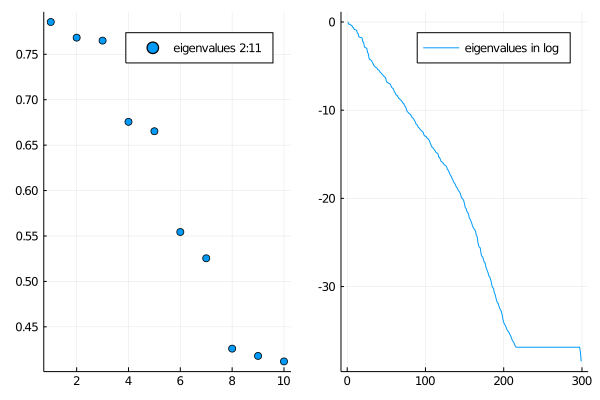

In [166]:
v, s = get_eig(Q , d_sq);
p1 = scatter(s[2:11], label="eigenvalues 2:11");
p2 = plot(log.(s), label="eigenvalues in log");
plot(p1, p2, layout=2)

## 6. Define a diffusion map 

Let $Y$ be a diffusion map, which map corrdinates between data and diffusion space, with its column
$$Y_i=
\begin{bmatrix}
p_t(x_i,x_1) \\
p_t(x_i,x_2) \\
\vdots       \\
p_t(x_i,x_n) \\
\end{bmatrix}
= \left[ \lambda_i^t v_i \right] = P_{i}^t.$$

In [167]:
function get_Y(v, S, c)
    
    n = size(v,1);
    Y = zeros(n,c);
    
    # get components of diffusion map Y
    for ii = 1:c
        Y[:,ii] = v[:,ii+1].*S[ii+1];
    end
    
    return Y ;
end

get_Y (generic function with 1 method)

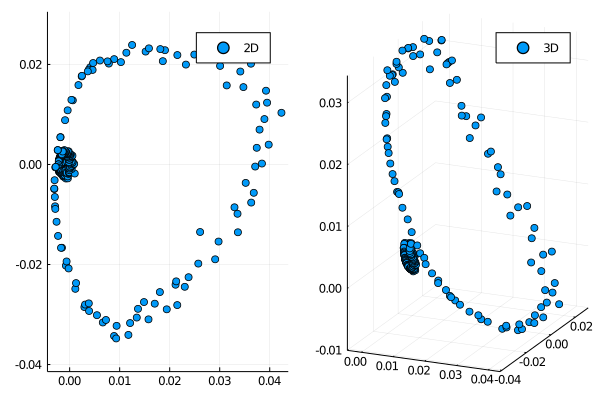

In [168]:
Y2 = get_Y(v, s, 2);
Y3 = get_Y(v, s, 3);

# print diffution map
p1 = scatter(Y2[:,1], Y2[:,2], label="2D", aspect_ratio=:equal)
p2 = scatter(Y3[:,1], Y3[:,2], Y3[:,3], label="3D", aspect_ratio=:equal)
plot(p1, p2, layout=2)

## 7. K-means Clustering

Using k-means method to get the labeling of the datas, here cluster is a manually select number of groups.

In [169]:
cluster = 3;
R2 = kmeans(transpose(Y2), cluster; maxiter=200, display=:iter);
group2 = assignments(R2); # get the assignments of points to clusters
center2 = transpose(R2.centers); # get the cluster centers

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       3.904396e-02
      1       3.395009e-02      -5.093872e-03 |        2
      2       3.327041e-02      -6.796785e-04 |        3
      3       3.237731e-02      -8.930985e-04 |        3
      4       3.138261e-02      -9.947016e-04 |        3
      5       2.866312e-02      -2.719497e-03 |        3
      6       2.464116e-02      -4.021957e-03 |        3
      7       2.063212e-02      -4.009039e-03 |        3
      8       1.927936e-02      -1.352755e-03 |        3
      9       1.884275e-02      -4.366138e-04 |        3
     10       1.855484e-02      -2.879152e-04 |        3
     11       1.832775e-02      -2.270868e-04 |        3
     12       1.821232e-02      -1.154237e-04 |        3
     13       1.814457e-02      -6.775275e-05 |        0
     14       1.814457e-02       0.000000e+00 |        0
K-means converged with 14 iterations (objv = 0.01814457

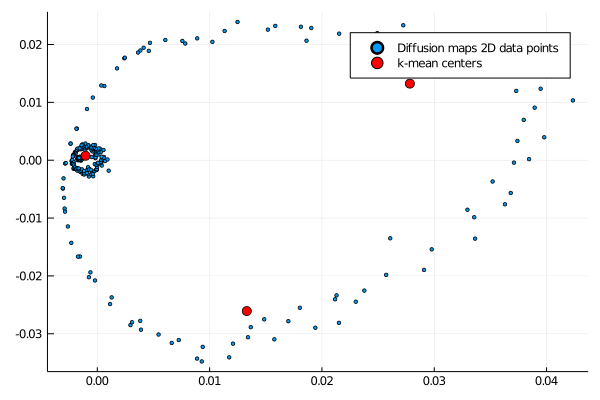

In [170]:
scatter(Y2[:,1] , Y2[:,2], markersize=:2, label="Diffusion maps 2D data points")
scatter!(center2[:,1], center2[:,2], markercolor=:red, markersize=:5, label="k-mean centers")

In [171]:
R3 = kmeans(transpose(Y3), cluster; maxiter=200, display=:iter);
group3 = assignments(R3); # get the assignments of points to clusters
center3 = transpose(R3.centers); # get the cluster centers

  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       5.583292e-02
      1       5.133649e-02      -4.496432e-03 |        3
      2       5.082641e-02      -5.100819e-04 |        3
      3       5.018226e-02      -6.441523e-04 |        3
      4       4.954412e-02      -6.381343e-04 |        2
      5       4.943985e-02      -1.042709e-04 |        0
      6       4.943985e-02       0.000000e+00 |        0
K-means converged with 6 iterations (objv = 0.04943985129757053)


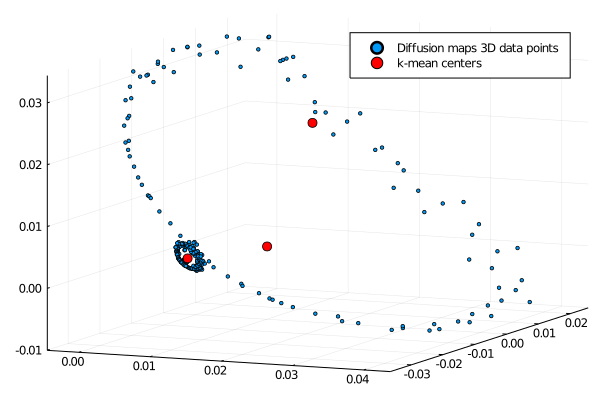

In [172]:
scatter(Y3[:,1], Y3[:,2], Y3[:,3], markersize=:2, label="Diffusion maps 3D data points")
scatter!(center3[:,1], center3[:,2], center3[:,3], markercolor=:red, markersize=:5, label="k-mean centers")

## 8. Show the result

visualize the results of clustering

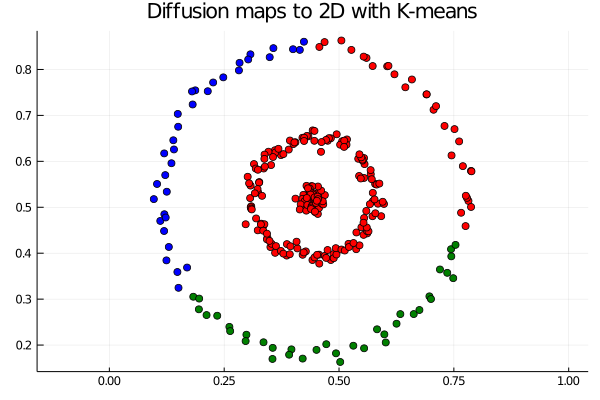

In [173]:
# select the color
dict = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "orange" , 5 => "cyan" , 6 => "brown" , 7 => "black");
color_group2 = Array{String}(undef, size(group2, 1));
for ii = 1 : size(group2, 1)
    color_group2[ii] = dict[group2[ii]];
end

# print
scatter(X[:,1] , X[:,2], c = color_group2, leg=false, aspect_ratio=:equal, title = "Diffusion maps to 2D with K-means")

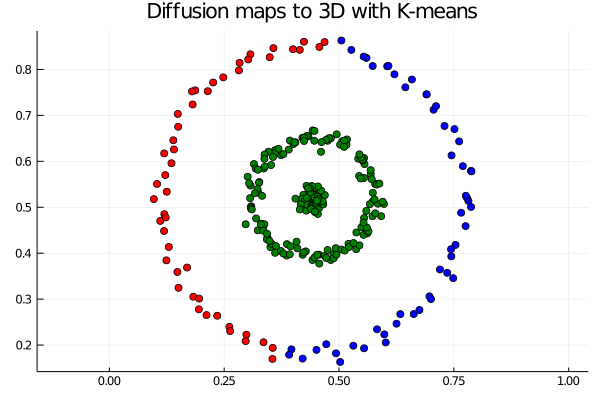

In [174]:
color_group3 = Array{String}(undef, size(group3, 1));
for ii = 1 : size(group3, 1)
    color_group3[ii] = dict[group3[ii]];
end

# print
scatter(X[:,1] , X[:,2], c = color_group3, leg=false, aspect_ratio=:equal, title = "Diffusion maps to 3D with K-means")